# Import des bibliothèque nécessaire

In [ ]:

import pandas as pd
import numpy as np
import duckdb
from google.colab import files
import re
import nltk
from nltk.corpus import stopwords, movie_reviews
from nltk.tokenize import word_tokenize
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from transformers import MarianMTModel, MarianTokenizer

# Ajuster les paramètres pour afficher plus de contenu
#pd.set_option('display.max_colwidth', None)  # Pas de limite pour la largeur des colonnes
#pd.set_option('display.max_rows', None)      # Afficher toutes les lignes (si la colonne est longue)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [ ]:
!pip install duckdb --upgrade

In [ ]:
#installation de la bibliothèque transformers de Hugging Face

!pip install transformers

In [ ]:
# Connexion à DuckDB
con = duckdb.connect()

# Étape 1 : Charger acteurs principaux avec leurs noms

In [ ]:
# Charger acteurs principaux avec leurs noms
query_actors_with_names = """
    SELECT p.tconst, p.nconst, n.primaryName AS actorName, p.ordering, p.characters
    FROM read_csv_auto(
        'https://datasets.imdbws.com/title.principals.tsv.gz',
        delim='\t', quote='', compression='gzip', header=True, nullstr='\\N', ignore_errors=True
    ) AS p
    JOIN read_csv_auto(
        'https://datasets.imdbws.com/name.basics.tsv.gz',
        delim='\t', quote='', compression='gzip', header=True, nullstr='\\N', ignore_errors=True
    ) AS n
    ON p.nconst = n.nconst
    WHERE p.category IN ('actor', 'actress') AND p.ordering <= 3
    ORDER BY p.tconst, p.ordering;
"""

# Exécuter la requête
actors_with_names = con.execute(query_actors_with_names).fetchdf()

# Afficher un aperçu
actors_with_names.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,nconst,actorName,ordering,characters
0,tt0000005,nm0443482,Charles Kayser,1,"[""Blacksmith""]"
1,tt0000005,nm0653042,John Ott,2,"[""Assistant""]"
2,tt0000007,nm0179163,James J. Corbett,1,None
3,tt0000007,nm0183947,Peter Courtney,2,None
4,tt0000008,nm0653028,Fred Ott,1,"[""Sneezing Man""]"


In [ ]:
actors_with_names.shape

(16093408, 5)

# Étape 2 : Charger réalisateurs avec leurs noms



In [ ]:
# Charger les réalisateurs depuis le fichier title.crew.tsv.gz
# Charger réalisateurs avec leurs noms
query_directors_with_names = """
    SELECT c.tconst, n.primaryName AS directorName
    FROM read_csv_auto(
        'https://datasets.imdbws.com/title.crew.tsv.gz',
        delim='\t', quote='', compression='gzip', header=True, nullstr='\\N', ignore_errors=True
    ) AS c
    JOIN read_csv_auto(
        'https://datasets.imdbws.com/name.basics.tsv.gz',
        delim='\t', quote='', compression='gzip', header=True, nullstr='\\N', ignore_errors=True
    ) AS n
    ON c.directors = n.nconst
    WHERE c.directors IS NOT NULL;
"""

# Exécuter la requête
directors_with_names = con.execute(query_directors_with_names).fetchdf()
directors_with_names.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,directorName
0,tt8413320,Ingmar Bergman
1,tt0050964,James Cagney
2,tt0073559,Kirk Douglas
3,tt11669728,Federico Fellini
4,tt0416238,John Gielgud


# Étape 3 : merge entre les acteurs et réalisateurs

In [ ]:
actors_and_directors = pd.merge(
    actors_with_names,
    directors_with_names,
    on='tconst',
    how='inner'  # Inclut uniquement les titres avec des acteurs et des réalisateurs
)

In [ ]:
actors_and_directors

,tconst,nconst,actorName,ordering,characters,directorName
0,tt0000005,nm0443482,Charles Kayser,1,"[""Blacksmith""]",William K.L. Dickson
1,tt0000005,nm0653042,John Ott,2,"[""Assistant""]",William K.L. Dickson
2,tt0000008,nm0653028,Fred Ott,1,"[""Sneezing Man""]",William K.L. Dickson
3,tt0000009,nm0063086,Blanche Bayliss,1,"[""Miss Geraldine Holbrook (Miss Jerry)""]",Alexander Black
4,tt0000009,nm0183823,William Courtenay,2,"[""Mr. Hamilton""]",Alexander Black
...,...,...,...,...,...,...
10110220,tt9916856,nm10538650,Anna Fitoussi,2,"[""Sandra""]",Johan Planefeldt
10110221,tt9916856,nm10538646,Andreas Demmel,3,"[""Stephan""]",Johan Planefeldt
10110222,tt9916880,nm2784764,Lizzie Waterworth,1,"[""Henry""]",Hilary Audus
10110223,tt9916880,nm1483166,Aidan Cook,2,"[""Rude Ralph""]",Hilary Audus


# Sauvegarde actors_and_directors en csv pour futur utilisation

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
actors_and_directors.to_csv('actors_and_directors.csv', index=False)

# Explications :
# - 'actors_and_directors.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

In [ ]:
# Étape 1 : Téléverser le fichier depuis l'ordinateur
result_tmdb = files.upload()

KeyboardInterrupt: 

In [ ]:
# Étape 2 : Charger le fichier CSV téléversé dans un DataFrame
# Remplacez 'votre_fichier.csv' par le nom exact du fichier téléversé
df_tmdb = pd.read_csv('/content/actors_and_directors.csv')
actors_and_directors.head()

,tconst,nconst,actorName,ordering,characters,directorName
0,tt0000005,nm0443482,Charles Kayser,1,"[""Blacksmith""]",William K.L. Dickson
1,tt0000005,nm0653042,John Ott,2,"[""Assistant""]",William K.L. Dickson
2,tt0000008,nm0653028,Fred Ott,1,"[""Sneezing Man""]",William K.L. Dickson
3,tt0000009,nm0063086,Blanche Bayliss,1,"[""Miss Geraldine Holbrook (Miss Jerry)""]",Alexander Black
4,tt0000009,nm0183823,William Courtenay,2,"[""Mr. Hamilton""]",Alexander Black


# chargement de title basics pour ne garder que les films des 5 dernières années (2020 à 2024)

In [ ]:
# Chargement du csv title basics et requête directe sur les fichiers compressés

result_title_basics = con.execute(f"""
    SELECT tconst, originalTitle, startYear, runtimeMinutes, genres
    FROM read_csv_auto('https://datasets.imdbws.com/title.basics.tsv.gz', delim='\t', quote='', ignore_errors=true)
    WHERE titleType = 'movie'
    AND startYear >= '2020'
    AND startYear <= '2024'
""").fetchdf()

result_title_basics

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,originalTitle,startYear,runtimeMinutes,genres
0,tt0062336,El tango del viudo y su espejo deformante,2020,70,Drama
1,tt0070596,El realismo socialista,2023,78,Drama
2,tt0077684,Histórias de Combóios em Portugal,2022,46,Documentary
3,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller"
4,tt0096167,Stars in Broad Daylight,2024,105,Drama
...,...,...,...,...,...
94561,tt9914192,No Gogó do Paulinho,2020,98,Comedy
94562,tt9914972,Blind Ambition,2021,96,Documentary
94563,tt9916190,Safeguard,2020,95,"Action,Adventure,Thriller"
94564,tt9916270,Il talento del calabrone,2020,84,Thriller


# merge title basics et les acteurs et directeurs

In [ ]:
movies_actors_directors = result_title_basics.merge(actors_and_directors, how='inner', left_on='tconst' , right_on='tconst')
movies_actors_directors

,tconst,originalTitle,startYear,runtimeMinutes,genres,nconst,actorName,ordering,characters,directorName
0,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000123,George Clooney,1,"[""Ron""]",André Szöts
1,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000368,Laura Dern,2,"[""Tina""]",André Szöts
2,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000221,Charlie Sheen,3,"[""Lance""]",André Szöts
3,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094804,Zuhair Abdlulkarim,1,"[""Kasser""]",Ossama Mohammed
4,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094997,Sabah As-Salem,2,"[""Sana""]",Ossama Mohammed
...,...,...,...,...,...,...,...,...,...,...
169272,tt9916270,Il talento del calabrone,2020,84,Thriller,nm3080119,Lorenzo Richelmy,2,"[""Dj Steph""]",Giacomo Cimini
169273,tt9916270,Il talento del calabrone,2020,84,Thriller,nm2063290,Anna Foglietta,3,"[""Rosa Amedei""]",Giacomo Cimini
169274,tt9916362,Akelarre,2020,92,"Drama,History",nm3766704,Amaia Aberasturi,1,"[""Ana""]",Pablo Agüero
169275,tt9916362,Akelarre,2020,92,"Drama,History",nm0107165,Alex Brendemühl,2,"[""Rostegui""]",Pablo Agüero


# chargements des ratings imdb

In [ ]:


# Chargement du csv title ratings et requête directe sur les fichiers compressés

result_title_ratings = con.execute(f"""
    SELECT *
    FROM read_csv_auto('https://datasets.imdbws.com/title.ratings.tsv.gz', delim='\t', quote='', ignore_errors=true)
""").fetchdf()

result_title_ratings

,tconst,averageRating,numVotes
0,tt0000001,5.7,2109
1,tt0000002,5.6,284
2,tt0000003,6.4,2135
3,tt0000004,5.3,182
4,tt0000005,6.2,2863
...,...,...,...
1513751,tt9916730,7.0,12
1513752,tt9916766,7.1,24
1513753,tt9916778,7.2,37
1513754,tt9916840,6.9,11


# merge ratings avec movies_actors_directors

In [ ]:
merge_imdb_total = movies_actors_directors.merge(result_title_ratings, how='left', left_on='tconst' , right_on='tconst')
merge_imdb_total

,tconst,originalTitle,startYear,runtimeMinutes,genres,nconst,actorName,ordering,characters,directorName,averageRating,numVotes
0,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000123,George Clooney,1,"[""Ron""]",André Szöts,2.7,1774.0
1,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000368,Laura Dern,2,"[""Tina""]",André Szöts,2.7,1774.0
2,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000221,Charlie Sheen,3,"[""Lance""]",André Szöts,2.7,1774.0
3,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094804,Zuhair Abdlulkarim,1,"[""Kasser""]",Ossama Mohammed,NaN,NaN
4,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094997,Sabah As-Salem,2,"[""Sana""]",Ossama Mohammed,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
169272,tt9916270,Il talento del calabrone,2020,84,Thriller,nm3080119,Lorenzo Richelmy,2,"[""Dj Steph""]",Giacomo Cimini,5.8,1493.0
169273,tt9916270,Il talento del calabrone,2020,84,Thriller,nm2063290,Anna Foglietta,3,"[""Rosa Amedei""]",Giacomo Cimini,5.8,1493.0
169274,tt9916362,Akelarre,2020,92,"Drama,History",nm3766704,Amaia Aberasturi,1,"[""Ana""]",Pablo Agüero,6.4,5967.0
169275,tt9916362,Akelarre,2020,92,"Drama,History",nm0107165,Alex Brendemühl,2,"[""Rostegui""]",Pablo Agüero,6.4,5967.0


# sauvegarde de merge_imdb_total

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
merge_imdb_total.to_csv('merge_imdb_total.csv', index=False)

# Explications :
# - 'merge_imdb_total.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

In [ ]:
# Étape 1 : Téléverser le fichier depuis l'ordinateur
result_imdb_total = files.upload()


Saving merge_imdb_total.csv to merge_imdb_total.csv


In [ ]:
# Étape 2 : Charger le fichier CSV téléversé dans un DataFrame
# Remplacez 'votre_fichier.csv' par le nom exact du fichier téléversé
df_imdb_total = pd.read_csv('/content/merge_imdb_total.csv')
df_imdb_total.head()

,tconst,originalTitle,startYear,runtimeMinutes,genres,nconst,actorName,ordering,characters,directorName,averageRating,numVotes
0,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000123,George Clooney,1,"[""Ron""]",André Szöts,2.7,1774.0
1,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000368,Laura Dern,2,"[""Tina""]",André Szöts,2.7,1774.0
2,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000221,Charlie Sheen,3,"[""Lance""]",André Szöts,2.7,1774.0
3,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094804,Zuhair Abdlulkarim,1,"[""Kasser""]",Ossama Mohammed,NaN,NaN
4,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094997,Sabah As-Salem,2,"[""Sana""]",Ossama Mohammed,NaN,NaN


# Chargement du csv tmdb et requête directe sur les fichiers compressés

In [ ]:
result_tmdb = con.execute(f"""
    SELECT *
    FROM read_csv_auto('/content/tmdb_full.csv', ignore_errors=true)
    WHERE original_language = 'fr'
    AND CAST(release_date AS DATE) >= DATE '2020-01-01'
    AND CAST(release_date AS DATE) <= DATE '2024-12-31'
    AND status = 'Released'
""").fetchdf()


In [ ]:
result_tmdb.head()

,adult,backdrop_path,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,production_companies_name,production_companies_country
0,False,None,1250,"['Thriller', 'Science Fiction']",None,1122079,tt27672999,fr,Vendetta,None,...,0,['fr'],Released,None,Vendetta,False,10.0,1,['Kino (FR)'],['']
1,False,/xtyxYV5VyAYrV0IISYlao77D8sW.jpg,0,['Documentary'],None,1121883,tt13974152,fr,Vieillir enfermés,None,...,0,[],Released,None,Vieillir enfermés,False,8.0,1,"['Camera Lucida Productions', 'ARTE']","['FR', 'FR']"
2,False,/o8quSROfTsgaAPyg88iLXVhFtmb.jpg,0,['Documentary'],https://www.youtube.com/watch?v=tJ3yK8loLxA,1120745,tt27653649,fr,"Alain Robert, Retour au Verdon","At 60, Alain Robert has become a legend around...",...,18,['fr'],Released,None,"Alain Robert, Retour au Verdon",False,10.0,1,['Puzzle Media'],['FR']
3,False,None,0,[],None,1120002,tt27641234,fr,"Japon, le combat d'un maître de thé",None,...,0,"['fr', 'ja']",Released,None,"Japon, le combat d'un maître de thé",False,0.0,0,[],[]
4,False,None,0,[],None,1119689,tt27301898,fr,Céline on a Cloudy Day,A Turkish-French actress prepares for an audit...,...,19,"['en', 'fr', 'tr']",Released,A Turkish-French actress prepares for an audit...,Céline on a Cloudy Day,False,0.0,0,[],[]


In [ ]:
result_tmdb.shape

(2072, 25)

In [ ]:
# supression des colonnes qui ne seront pas du tout utilisé
result_tmdb = result_tmdb.drop(['adult', 'backdrop_path', 'genres', 'homepage', 'id', 'original_language', 'status', 'tagline', 'video'], axis=1)

# merge imdb et tmdb

In [ ]:
df_imdb_tmdb_ = df_imdb_total.merge(result_tmdb, how='inner', left_on='tconst' , right_on='imdb_id')


# Sauvegarde de imdb et tmdb

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
df_imdb_tmdb_.to_csv('df_imdb_tmdb_.csv', index=False)

# Explications :
# - 'df_imdb_tmdb_.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

# Analyse, modification et suppression de colonne

In [ ]:
# Étape 1 : Téléverser le fichier depuis l'ordinateur
result_imdb_total = files.upload()


Saving df_imdb_tmdb.csv to df_imdb_tmdb.csv


In [ ]:
# Étape 2 : Charger le fichier CSV téléversé dans un DataFrame
# Remplacez 'votre_fichier.csv' par le nom exact du fichier téléversé
df_imdb_tmdb = pd.read_csv('/content/df_imdb_tmdb.csv')
df_imdb_tmdb.head()

,tconst,originalTitle,startYear,runtimeMinutes,genres,nconst,actorName,ordering,characters,directorName,...,production_countries_y,release_date_y,revenue_y,runtime_y,spoken_languages_y,title_y,vote_average_y,vote_count_y,production_companies_name_y,production_companies_country_y
0,tt10019108,Villa Caprice,2020,103,"Crime,Drama",nm0034390,Niels Arestrup,1,"[""Luc Germon""]",Bernard Stora,...,"['BE', 'FR']",2021-06-02,0,103,['fr'],Villa Caprice,5.625,36,"['JPG Films', 'uMedia', 'uFund', 'Bac Films']","['FR', 'BE', 'BE', 'FR']"
1,tt10019108,Villa Caprice,2020,103,"Crime,Drama",nm0115730,Patrick Bruel,2,"[""Gilles Fontaine""]",Bernard Stora,...,"['BE', 'FR']",2021-06-02,0,103,['fr'],Villa Caprice,5.625,36,"['JPG Films', 'uMedia', 'uFund', 'Bac Films']","['FR', 'BE', 'BE', 'FR']"
2,tt10019108,Villa Caprice,2020,103,"Crime,Drama",nm0001393,Irène Jacob,3,"[""Nancy Fontaine""]",Bernard Stora,...,"['BE', 'FR']",2021-06-02,0,103,['fr'],Villa Caprice,5.625,36,"['JPG Films', 'uMedia', 'uFund', 'Bac Films']","['FR', 'BE', 'BE', 'FR']"
3,tt10023150,Mon cousin,2020,104,Comedy,nm0512071,Vincent Lindon,1,"[""Pierre Pastié""]",Jan Kounen,...,['FR'],2020-09-30,2982559,107,['fr'],My Cousin,5.500,90,"['Eskwad', 'TF1 Films Production', 'uMedia', '...","['FR', 'FR', 'BE', 'BE']"
4,tt10023150,Mon cousin,2020,104,Comedy,nm12571544,Matei Dussarps,2,"[""Adrien jeune""]",Jan Kounen,...,['FR'],2020-09-30,2982559,107,['fr'],My Cousin,5.500,90,"['Eskwad', 'TF1 Films Production', 'uMedia', '...","['FR', 'FR', 'BE', 'BE']"


## suppression de tout les colonnes doublons

In [ ]:
# check les noms des colonnes pour suppression
df_imdb_tmdb.columns

Index(['tconst', 'originalTitle', 'startYear', 'runtimeMinutes', 'genres',
       'nconst', 'actorName', 'ordering', 'characters', 'directorName',
       'averageRating', 'numVotes', 'budget_x', 'imdb_id_x',
       'original_title_x', 'overview_x', 'popularity_x', 'poster_path_x',
       'production_countries_x', 'release_date_x', 'revenue_x', 'runtime_x',
       'spoken_languages_x', 'title_x', 'vote_average_x', 'vote_count_x',
       'production_companies_name_x', 'production_companies_country_x',
       'budget_y', 'imdb_id_y', 'original_title_y', 'overview_y',
       'popularity_y', 'poster_path_y', 'production_countries_y',
       'release_date_y', 'revenue_y', 'runtime_y', 'spoken_languages_y',
       'title_y', 'vote_average_y', 'vote_count_y',
       'production_companies_name_y', 'production_companies_country_y'],
      dtype='object')

In [ ]:
# suppression de tout les colonnes doublons
df_imdb_tmdb = df_imdb_tmdb.drop(['nconst', 'ordering', 'imdb_id_x',
       'original_title_x', 'release_date_x', 'runtime_x', 'budget_y', 'imdb_id_y', 'original_title_y', 'overview_y',
       'popularity_y', 'poster_path_y', 'production_countries_y',
       'release_date_y', 'revenue_y', 'runtime_y', 'spoken_languages_y',
       'title_y', 'vote_average_y', 'vote_count_y',
       'production_companies_name_y', 'production_companies_country_y'], axis=1)

In [ ]:
# check lignes et colonnes
df_imdb_tmdb.shape

(2199, 22)

## analyses des 2 colonnes moyenne des notes pour n'en garder q'une

In [ ]:
df_imdb_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tconst                          2199 non-null   object 
 1   originalTitle                   2199 non-null   object 
 2   startYear                       2199 non-null   int64  
 3   runtimeMinutes                  2199 non-null   object 
 4   genres                          2199 non-null   object 
 5   actorName                       2199 non-null   object 
 6   characters                      2036 non-null   object 
 7   directorName                    2199 non-null   object 
 8   averageRating                   2057 non-null   float64
 9   numVotes                        2057 non-null   float64
 10  budget_x                        2199 non-null   int64  
 11  overview_x                      2121 non-null   object 
 12  popularity_x                    21

In [ ]:
# observation des statistiques pour les notes moyennes des 2 colonnes pour futur remplacements
df_imdb_tmdb[['averageRating', 'vote_average_x']].describe()

,averageRating,vote_average_x
count,2057.000000,2199.000000
mean,5.962615,5.042015
std,0.845610,2.531322
min,2.700000,0.000000
25%,5.500000,4.625000
50%,6.100000,5.870000
75%,6.500000,6.645000
max,8.700000,10.000000


In [ ]:
# Fonction pour extraire les moyenne des notes via TMDB API afin de pouvoir faire une mise à jour
# car on constate qu'il n'y a pas de valeur manquante mais beaucoup de valeur à 0 et d'autres à 10 qui fausse les statistiques global

def extraire_moyenne_note(id_film):
    API_KEY = "e7bd01225df3569a1a41477ab0718701"  # Votre clé TMDB
    url = f"https://api.themoviedb.org/3/find/{id_film}?api_key={API_KEY}&external_source=imdb_id"

    try:
        # Requête API
        response = requests.get(url)
        response.raise_for_status()  # Vérifie les erreurs HTTP
        data = response.json()

        # Vérifie si le film est trouvé
        if 'movie_results' in data and len(data['movie_results']) > 0:
            # Retourne la note moyenne
            return data['movie_results'][0].get('vote_average', 'Note non disponible')
        else:
            return 'Film non trouvé sur TMDB'
    except Exception as e:
        return f"Erreur: {e}"  # Capture les erreurs



In [ ]:
# Ajout des notes moyennes dans une nouvelle colonne
df_imdb_tmdb['vote_average_x'] = df_imdb_tmdb['tconst'].apply(extraire_moyenne_note)

# Afficher les résultats
print(df_imdb_tmdb[['tconst', 'vote_average_x']])


          tconst  vote_average_x
0     tt10019108           5.521
1     tt10019108           5.521
2     tt10019108           5.521
3     tt10023150           5.475
4     tt10023150           5.475
...          ...             ...
2194   tt9894450           7.000
2195   tt9894450           7.000
2196   tt9908390           5.316
2197   tt9908390           5.316
2198   tt9908390           5.316

[2199 rows x 2 columns]


In [ ]:
# verification des statistiques après mise à jour
df_imdb_tmdb[['averageRating', 'vote_average_x']].describe()

,averageRating,vote_average_x
count,2057.000000,2199.000000
mean,5.962615,5.511515
std,0.845610,1.891919
min,2.700000,0.000000
25%,5.500000,5.200000
50%,6.100000,6.000000
75%,6.500000,6.600000
max,8.700000,10.000000


La mise à jour n'a pas changer grand, nous allons tenter de remplacer les valeurs manquantes dans averageRating et voir ce que cela donne

In [ ]:
# récupérer indice films contenant des valeurs manquantes
id_film_moyenne_note_manquant = df_imdb_tmdb['tconst'].loc[df_imdb_tmdb['averageRating'].isna() == True].to_list()

# récupérer moyenne via l'API est des valeurs manquantes est les changes
API_KEY = "e7bd01225df3569a1a41477ab0718701"

notes = {}
for tconst in id_film_moyenne_note_manquant:
  url = f"https://api.themoviedb.org/3/find/{tconst}?api_key={API_KEY}&external_source=imdb_id&language=fr"

  response = requests.get(url)
  rep = response.json()
  note = rep['movie_results'][0]['vote_average']
  df_imdb_tmdb.loc[df_imdb_tmdb['tconst'] == tconst, 'averageRating'] = note

  # mettre d'en une liste afin de pouvoir regarder si toutes les valeurs ont bien été changé
  notes[tconst] = note

notes


{'tt10608566': 8.0,
 'tt11346952': 0.0,
 'tt11681890': 0.0,
 'tt11846664': 0.0,
 'tt12509388': 0.0,
 'tt12554252': 0.0,
 'tt12989690': 5.0,
 'tt13129482': 0.0,
 'tt13335652': 5.0,
 'tt13893276': 0.0,
 'tt14083354': 0.0,
 'tt14260194': 0.0,
 'tt14525282': 5.7,
 'tt14526332': 0.0,
 'tt14785272': 0.0,
 'tt14813610': 6.0,
 'tt14917988': 6.0,
 'tt15204094': 3.8,
 'tt15271018': 0.0,
 'tt17093164': 2.0,
 'tt17492142': 0.0,
 'tt18250838': 0.0,
 'tt19363118': 0.0,
 'tt19623256': 0.0,
 'tt19631488': 4.0,
 'tt19731434': 1.0,
 'tt20090310': 8.0,
 'tt20874576': 0.0,
 'tt21264860': 0.0,
 'tt21276150': 0.0,
 'tt21368220': 3.0,
 'tt21438254': 0.0,
 'tt21971760': 0.0,
 'tt22206894': 0.0,
 'tt22258058': 0.0,
 'tt22301442': 0.0,
 'tt22743908': 6.0,
 'tt22774286': 0.0,
 'tt22797370': 0.0,
 'tt23503226': 0.0,
 'tt23781234': 5.5,
 'tt24246948': 9.0,
 'tt26259838': 0.0,
 'tt26351396': 0.0,
 'tt26681224': 8.0,
 'tt27052871': 8.0,
 'tt27158827': 6.5,
 'tt27198711': 0.0,
 'tt8801348': 0.0,
 'tt9597902': 0.0}

In [ ]:
# verification des statistiques après mise à jour
df_imdb_tmdb[['averageRating', 'vote_average_x']].describe()

,averageRating,vote_average_x
count,2199.000000,2199.000000
mean,5.702228,5.511515
std,1.484092,1.891919
min,0.000000,0.000000
25%,5.400000,5.200000
50%,6.000000,6.000000
75%,6.500000,6.600000
max,9.000000,10.000000


In [ ]:
# observation des valeurs égal à 0
len(df_imdb_tmdb['tconst'].loc[df_imdb_tmdb['averageRating'] == 0].unique().tolist())


32

cela représente 32 films, nous allons les supprimer afin de ne pas faussé le model nn par la suite

In [ ]:
df_imdb_tmdb = df_imdb_tmdb.loc[df_imdb_tmdb['averageRating'] != 0]

In [ ]:
df_imdb_tmdb['averageRating'].describe()

,averageRating
count,2107.000000
mean,5.951210
std,0.903492
min,1.000000
25%,5.500000
50%,6.000000
75%,6.500000
max,9.000000


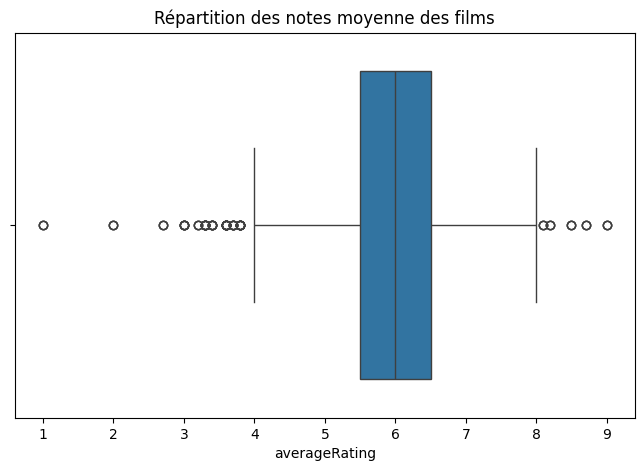

In [ ]:
# répartition dans un boxplot pour voir sa distribution

# Création du diagramme à barres pour illustrer les moyennes des notes des films
fig, axes = plt.subplots(figsize=(8, 5))
sns.boxplot(x="averageRating", data=df_imdb_tmdb)

# Ajout des titres et labels
plt.title("Répartition des notes moyenne des films")

# Affichage du graphique
plt.show()

## analyses des 2 colonnes mombres des notes pour n'en garder q'une

In [ ]:
# observation des statistiques pour les notes moyennes des 2 colonnes pour futur remplacements
df_imdb_tmdb[['numVotes', 'vote_count_x']].describe()

,numVotes,vote_count_x
count,2057.000000,2107.000000
mean,1575.384054,64.637874
std,4427.921024,132.315260
min,6.000000,0.000000
25%,130.000000,2.000000
50%,362.000000,14.000000
75%,1069.000000,59.000000
max,60261.000000,1192.000000


nous allons directement remplacer le nombre de votes manquant par les valeurs de l'API si elle existe et supprimer les valeurs à 0 si il en a comme pour la colonneaverageRating

In [ ]:
# récupérer indice films contenant des valeurs manquantes
id_film_moyenne_note_manquant = df_imdb_tmdb['tconst'].loc[df_imdb_tmdb['numVotes'].isna() == True].to_list()

# récupérer moyenne via l'API est des valeurs manquantes est les changes
API_KEY = "e7bd01225df3569a1a41477ab0718701"

votes = {}
for tconst in id_film_moyenne_note_manquant:
  url = f"https://api.themoviedb.org/3/find/{tconst}?api_key={API_KEY}&external_source=imdb_id&language=fr"

  response = requests.get(url)
  rep = response.json()
  vote = rep['movie_results'][0]['vote_count']
  df_imdb_tmdb.loc[df_imdb_tmdb['tconst'] == tconst, 'numVotes'] = vote

  # mettre d'en une liste afin de pouvoir regarder si toutes les valeurs ont bien été changé
  votes[tconst] = vote

votes

{'tt10608566': 1,
 'tt12989690': 2,
 'tt13335652': 1,
 'tt14525282': 3,
 'tt14813610': 1,
 'tt14917988': 1,
 'tt15204094': 2,
 'tt17093164': 1,
 'tt19631488': 2,
 'tt19731434': 1,
 'tt20090310': 1,
 'tt21368220': 1,
 'tt22743908': 1,
 'tt23781234': 1,
 'tt24246948': 1,
 'tt26681224': 1,
 'tt27052871': 1,
 'tt27158827': 4}

In [ ]:
df_imdb_tmdb['numVotes'].describe()

,numVotes
count,2107.000000
mean,1538.032748
std,4381.599710
min,1.000000
25%,116.000000
50%,334.000000
75%,1037.000000
max,60261.000000


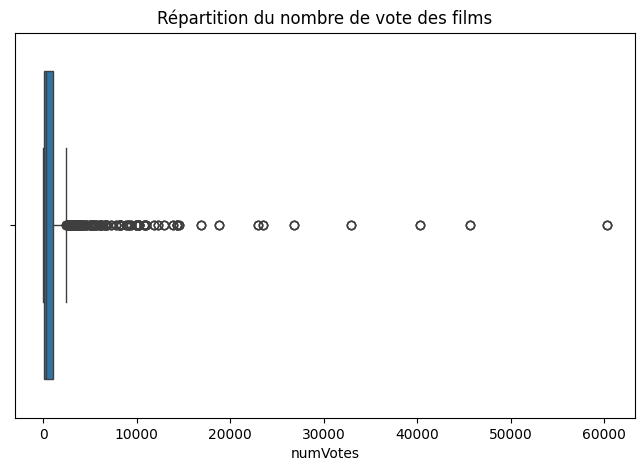

In [ ]:
# répartition dans un boxplot pour voir sa distribution

# Création du diagramme à barres pour illustrer la répartition du nombre de votes par films
fig, axes = plt.subplots(figsize=(8, 5))
sns.boxplot(x="numVotes", data=df_imdb_tmdb)

# Ajout des titres et labels
plt.title("Répartition du nombre de vote des films")

# Affichage du graphique
plt.show()

In [ ]:
# vérification des valeurs manquantes des colonnes
df_imdb_tmdb.isna().sum()

,0
tconst,0
originalTitle,0
startYear,0
runtimeMinutes,0
genres,0
actorName,0
characters,141
directorName,0
averageRating,0
numVotes,0


## gérer les valeurs manquantes de poster_path_x

In [ ]:
# récupérer les id des valeurs manquantes
id_film_poster = df_imdb_tmdb['tconst'].loc[df_imdb_tmdb['poster_path_x'].isna() == True].tolist()

# nous allons tenter de remplacer les valeurs manquantes avec l'API
API_KEY = "e7bd01225df3569a1a41477ab0718701"

posters = {}
for tconst in id_film_poster:
  url = f"https://api.themoviedb.org/3/find/{tconst}?api_key={API_KEY}&external_source=imdb_id&language=fr"

  response = requests.get(url)
  rep = response.json()
  poster = rep['movie_results'][0]['poster_path']
  df_imdb_tmdb.loc[df_imdb_tmdb['tconst'] == tconst, 'poster_path_x'] = poster

  # mettre d'en une liste afin de pouvoir regarder si toutes les valeurs ont bien été changé
  posters[tconst] = poster

posters

{'tt13846442': '/e161kuH60Kv5lnCPoevcbNCbCph.jpg',
 'tt14495660': '/31dkjJJty4gVA2t5LKi2WBd9x15.jpg',
 'tt15464982': '/2UZEzrOgCysI3VHL9KHalYbNHZt.jpg',
 'tt19381382': '/nAp0VzDEOn7rvHrc63DHqrMOqK4.jpg',
 'tt20455254': '/dtMrGc0iEvB4FiinWRwTAXr05ft.jpg',
 'tt23875604': None,
 'tt26255358': '/sKvV0KfOG8dXaYqitmNXIRkVeO1.jpg',
 'tt27052871': '/9Gy8rI4dMdr5iHQHfqmLPW6W7Sg.jpg',
 'tt27158088': '/cNVFQE3csizaUR8paNhy7T6KD8o.jpg'}

In [ ]:
# vérification des valeurs manquantes des colonnes
df_imdb_tmdb['poster_path_x'].isna().sum()

3

In [ ]:
# visualisation de ce films
# il n'est pas interressant pour nos 3 thèmes, on va donc le supprimer
df_imdb_tmdb.loc[df_imdb_tmdb['poster_path_x'].isna() == True]

,tconst,originalTitle,startYear,runtimeMinutes,genres,actorName,characters,directorName,averageRating,numVotes,...,popularity_x,poster_path_x,production_countries_x,revenue_x,spoken_languages_x,title_x,vote_average_x,vote_count_x,production_companies_name_x,production_companies_country_x
1868,tt23875604,Thugs of Ramaghada,2023,118,"Crime,Drama",Chandan Raj,NaN,Karthik Maralabhavi,7.8,1282.0,...,0.84,None,['IN'],0,['kn'],Thugs of Ramaghada,6.0,0,[],[]
1869,tt23875604,Thugs of Ramaghada,2023,118,"Crime,Drama",Ashwin Hassan,NaN,Karthik Maralabhavi,7.8,1282.0,...,0.84,None,['IN'],0,['kn'],Thugs of Ramaghada,6.0,0,[],[]
1870,tt23875604,Thugs of Ramaghada,2023,118,"Crime,Drama",Mahalakshmi,NaN,Karthik Maralabhavi,7.8,1282.0,...,0.84,None,['IN'],0,['kn'],Thugs of Ramaghada,6.0,0,[],[]


In [ ]:
df_imdb_tmdb = df_imdb_tmdb.loc[df_imdb_tmdb['poster_path_x'].isna() != True]

## gérer les valeurs manquantes de overview_x

In [ ]:
# récupérer les id des valeurs manquantes
id_film_poster = df_imdb_tmdb['tconst'].loc[df_imdb_tmdb['overview_x'].isna() == True].tolist()

# nous allons tenter de remplacer les valeurs manquantes avec l'API
API_KEY = "e7bd01225df3569a1a41477ab0718701"

descriptions = {}
for tconst in id_film_poster:
  url = f"https://api.themoviedb.org/3/find/{tconst}?api_key={API_KEY}&external_source=imdb_id&language=en"

  response = requests.get(url)
  rep = response.json()
  description = rep['movie_results'][0]['overview']
  df_imdb_tmdb.loc[df_imdb_tmdb['tconst'] == tconst, 'overview_x'] = description

  # mettre d'en une liste afin de pouvoir regarder si toutes les valeurs ont bien été changé
  descriptions[tconst] = description

descriptions

{'tt10257496': '',
 'tt10608566': '',
 'tt11179020': "A couple since high school, Charlotte and Adam have just had their first child. But they're not happy, and habits are gradually replacing enthusiasm, to the point of driving them apart... Hoping to recapture the momentum of their early days, they decide to become guinea pigs in a revolutionary treatment designed to strengthen their bond and desire.",
 'tt12205746': "Éva, thirty-nine, lives alone. She would like to have a child. She may not have much time left. A gynecologist has just told her that her ovarian reserve is deplorable. The countdown begins. But she's instinctive, a bit messy and her battle plan lacks precision.",
 'tt12219112': '',
 'tt12474292': '',
 'tt13952880': '',
 'tt14451878': '',
 'tt14525282': '',
 'tt14852752': "During the reign of King Louis X the Hutin, his wife Marguerite indulged in parties of pleasure in the secrecy of the Tour de Nesle. Her young lovers were also her victims, and she had them murdered to

In [ ]:
# on observe les differents qui n'ont pas reçu de description, on s'aperçois qu'ils n'ont aucun rapport avec nos futurs thèmes.
df_imdb_tmdb.loc[df_imdb_tmdb['overview_x'] == '']

,tconst,originalTitle,startYear,runtimeMinutes,genres,actorName,characters,directorName,averageRating,numVotes,...,popularity_x,poster_path_x,production_countries_x,revenue_x,spoken_languages_x,title_x,vote_average_x,vote_count_x,production_companies_name_x,production_companies_country_x
54,tt10257496,Noni - Le fruit de l'espoir,2020,80,Drama,Sylvia Pouget,"[""Angeli""]",Alain Williams,2.7,13.0,...,0.605,/ZKgUL8gFOA2E59HiArB14FC18.jpg,['FR'],0,['fr'],Le Fruit de l'espoir,0.0,0,['Starvision World'],['']
55,tt10257496,Noni - Le fruit de l'espoir,2020,80,Drama,Robert Hossein,"[""Le grand-père d'Angeli""]",Alain Williams,2.7,13.0,...,0.605,/ZKgUL8gFOA2E59HiArB14FC18.jpg,['FR'],0,['fr'],Le Fruit de l'espoir,0.0,0,['Starvision World'],['']
56,tt10257496,Noni - Le fruit de l'espoir,2020,80,Drama,Raghunath Manet,NaN,Alain Williams,2.7,13.0,...,0.605,/ZKgUL8gFOA2E59HiArB14FC18.jpg,['FR'],0,['fr'],Le Fruit de l'espoir,0.0,0,['Starvision World'],['']
159,tt10608566,Old Boys,2022,\N,\N,Bernard Verley,"[""Paul""]",Jean-François Amiguet,8.0,1.0,...,0.600,/fD1lvpxf9S3zHTdYK1UbB0xkT15.jpg,['CH'],0,['fr'],Old Boys,8.0,1,[],[]
160,tt10608566,Old Boys,2022,\N,\N,Zoé,"[""Eugène""]",Jean-François Amiguet,8.0,1.0,...,0.600,/fD1lvpxf9S3zHTdYK1UbB0xkT15.jpg,['CH'],0,['fr'],Old Boys,8.0,1,[],[]
161,tt10608566,Old Boys,2022,\N,\N,Janine Piguet,"[""Bibi""]",Jean-François Amiguet,8.0,1.0,...,0.600,/fD1lvpxf9S3zHTdYK1UbB0xkT15.jpg,['CH'],0,['fr'],Old Boys,8.0,1,[],[]
468,tt12219112,Heaven Beneath My Feet,2020,90,Documentary,Lina Arar,NaN,Sandra Madi,6.9,8.0,...,0.600,/iBzuMQJvbHNwd4rDOsQgVspUC1L.jpg,[],0,[],Le paradis sous mes pieds,0.0,0,"[""Les Films d'Ici Méditerranée"", 'Red Carbon P...","['FR', '', '']"
469,tt12219112,Heaven Beneath My Feet,2020,90,Documentary,Fatima Hamza,NaN,Sandra Madi,6.9,8.0,...,0.600,/iBzuMQJvbHNwd4rDOsQgVspUC1L.jpg,[],0,[],Le paradis sous mes pieds,0.0,0,"[""Les Films d'Ici Méditerranée"", 'Red Carbon P...","['FR', '', '']"
470,tt12219112,Heaven Beneath My Feet,2020,90,Documentary,Abir Hashem,NaN,Sandra Madi,6.9,8.0,...,0.600,/iBzuMQJvbHNwd4rDOsQgVspUC1L.jpg,[],0,[],Le paradis sous mes pieds,0.0,0,"[""Les Films d'Ici Méditerranée"", 'Red Carbon P...","['FR', '', '']"
519,tt12474292,Cas Communautaire,2020,90,Drama,Adama Admow Diop,"[""Omar""]",Mara Zizou Fall,8.5,15.0,...,0.858,/vgP3VPx5O6hXnqa4maggY3HYjVf.jpg,[],0,['fr'],Cas Communautaire,6.0,0,['nuWorld Media Group'],['']


In [ ]:
# on décide donc de les supprimer
df_imdb_tmdb = df_imdb_tmdb.loc[df_imdb_tmdb['overview_x'] != '']

## création de colonnes pour les descriptions en français toujours grâce à l'API tmdb

In [ ]:
# Fonction pour extraire les descriptions en français via TMDB API


def extraire_description_fr(id_film):
    API_KEY = "e7bd01225df3569a1a41477ab0718701"  # Votre clé TMDB
    url = f"https://api.themoviedb.org/3/find/{id_film}?api_key={API_KEY}&external_source=imdb_id&language=fr"

    try:
        # Requête API
        response = requests.get(url)
        response.raise_for_status()  # Vérifie les erreurs HTTP
        data = response.json()

        # Vérifie si le film est trouvé
        if 'movie_results' in data and len(data['movie_results']) > 0:
            # Retourne la note moyenne
            return data['movie_results'][0].get('overview', 'Note non disponible')
        else:
            return 'Film non trouvé sur TMDB'
    except Exception as e:
        return f"Erreur: {e}"  # Capture les erreurs



In [ ]:
# Ajout des descriptions en français dans une nouvelle colonne
df_imdb_tmdb['description_fr'] = df_imdb_tmdb['tconst'].apply(extraire_description_fr)

# Afficher les résultats
df_imdb_tmdb[['tconst', 'description_fr']]

,tconst,description_fr
0,tt10019108,"Avocat célèbre, Luc Germon pense atteindre la ..."
1,tt10019108,"Avocat célèbre, Luc Germon pense atteindre la ..."
2,tt10019108,"Avocat célèbre, Luc Germon pense atteindre la ..."
3,tt10023150,Pierre est le PDG du groupe Pastié qui réunit ...
4,tt10023150,Pierre est le PDG du groupe Pastié qui réunit ...
...,...,...
2194,tt9894450,"Pour Tim et Chloé, le bonheur c'est au jour le..."
2195,tt9894450,"Pour Tim et Chloé, le bonheur c'est au jour le..."
2196,tt9908390,"Pour l’aider à retrouver sa fiancée disparue, ..."
2197,tt9908390,"Pour l’aider à retrouver sa fiancée disparue, ..."


In [ ]:
# vérification qu'il ny a pas de manquant
df_imdb_tmdb.loc[df_imdb_tmdb['description_fr'] == 'Note non disponible']

,tconst,originalTitle,startYear,runtimeMinutes,genres,actorName,characters,directorName,averageRating,numVotes,...,poster_path_x,production_countries_x,revenue_x,spoken_languages_x,title_x,vote_average_x,vote_count_x,production_companies_name_x,production_companies_country_x,description_fr


In [ ]:
# vérification à nouveau des valeurs manquants
# laise pour le moments les films n'ayants pas de characters, ne n'ai pas important pour notre model
df_imdb_tmdb.isna().sum()

,0
tconst,0
originalTitle,0
startYear,0
runtimeMinutes,0
genres,0
actorName,0
characters,131
directorName,0
averageRating,0
numVotes,0


## suppression des colonnes qui ne sont pas utile pour la suite

In [ ]:
# 81% de valeurs à 0, prévoir suppression colonnes
df_imdb_tmdb['budget_x'].value_counts(True)

,proportion
budget_x,
0,0.810668
5000000,0.005766
1200000,0.005766
3900000,0.005766
4000000,0.004325
...,...
1300000,0.001442
35000000,0.001442
17516235,0.001442


In [ ]:
# 90% de valeurs à 0, prévoir suppression colonnes
df_imdb_tmdb['revenue_x'].value_counts(True)

,proportion
revenue_x,
0,0.904853
1162077,0.001442
1512938,0.001442
288661,0.001442
2551835,0.001442
...,...
1024575,0.001442
2178083,0.001442
2627605,0.001442


In [ ]:
df_imdb_tmdb.columns

Index(['tconst', 'originalTitle', 'startYear', 'runtimeMinutes', 'genres',
       'actorName', 'characters', 'directorName', 'averageRating', 'numVotes',
       'budget_x', 'overview_x', 'popularity_x', 'poster_path_x',
       'production_countries_x', 'revenue_x', 'spoken_languages_x', 'title_x',
       'vote_average_x', 'vote_count_x', 'production_companies_name_x',
       'production_companies_country_x', 'description_fr'],
      dtype='object')

In [ ]:
# suppression des colonnes inutiles
df_imdb_tmdb = df_imdb_tmdb.drop(['budget_x', 'production_countries_x', 'revenue_x', 'spoken_languages_x', 'title_x',
       'vote_average_x', 'vote_count_x', 'production_companies_name_x',
       'production_companies_country_x'], axis=1)

In [ ]:
df_imdb_tmdb.shape

(2081, 14)

## renommer les colonnes

In [ ]:
# renommer les titres des colonnes
df_imdb_tmdb = df_imdb_tmdb.rename(columns={
    'tconst' : 'id_film',
    'originalTitle' : 'titre_original',
    'startYear' : 'annee_sortie',
    'runtimeMinutes' : 'duree',
    'actorName' : 'acteurs',
    'characters' : 'personnage_film',
    'directorName' : 'directeur',
    'averageRating' : 'moyenne_notes',
    'numVotes' : 'nombre_votes',
    'overview_x' : 'description_en',
    'popularity_x' : 'popularite',
    'poster_path_x' : 'chemin_affiche'

})

## modification apparence et type de la colonne

In [ ]:
# vérification du type avant d'appliquer eval
df_imdb_tmdb['personnage_film'].apply(type).value_counts()


,count
personnage_film,
<class 'str'>,1950
<class 'float'>,131


In [ ]:
# ces valeurs foat sont en réalité des valeur manquantes
df_imdb_tmdb.loc[df_imdb_tmdb['personnage_film'].apply(type) == float]


,id_film,titre_original,annee_sortie,duree,genres,acteurs,personnage_film,directeur,moyenne_notes,nombre_votes,description_en,popularite,chemin_affiche,description_fr
42,tt10230290,Matares,2020,90,Drama,Ali Damiche,NaN,Mohamed Rachid Benhadj,7.2,51.0,A drama about immigration and the fight for su...,1.353,/64nRPW7eqiB5ziy4KDXWJkqFGiC.jpg,"À Tipasa, ville côtière algérienne connue pour..."
322,tt11302336,Des hommes de paille,2021,88,Thriller,Emile Berling,NaN,Jonathan Safir,4.8,34.0,"A simple and quiet young man, Ruben faces the ...",0.945,/z1JCa5Mr2ip7Knw0sU9fEKKW6bj.jpg,"Jeune homme simple et tranquille, Ruben fait f..."
323,tt11302336,Des hommes de paille,2021,88,Thriller,Félix Cohen,NaN,Jonathan Safir,4.8,34.0,"A simple and quiet young man, Ruben faces the ...",0.945,/z1JCa5Mr2ip7Knw0sU9fEKKW6bj.jpg,"Jeune homme simple et tranquille, Ruben fait f..."
324,tt11302336,Des hommes de paille,2021,88,Thriller,Sophie Dumont,NaN,Jonathan Safir,4.8,34.0,"A simple and quiet young man, Ruben faces the ...",0.945,/z1JCa5Mr2ip7Knw0sU9fEKKW6bj.jpg,"Jeune homme simple et tranquille, Ruben fait f..."
476,tt12275282,Pyrale,2020,48,"Documentary,Sci-Fi",Lucienne Gaucherand,NaN,Roxanne Gaucherand,6.9,33.0,"Summer 2016, somewhere in French provencal Drô...",1.400,/uXJpY0TosSAdfklniEyK2zJM28c.jpg,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,tt8283360,Aland,2020,76,Drama,Thomas Germaine,NaN,Thomas Germaine,4.2,6.0,A father runs away form his house after killin...,0.600,/gqiIzSUp9CYBewqVTM8RjCYgcrj.jpg,"Dans un paysage de forêt glaciale, un plan séq..."
2071,tt8283360,Aland,2020,76,Drama,Gaspard Martin-Laprade,NaN,Thomas Germaine,4.2,6.0,A father runs away form his house after killin...,0.600,/gqiIzSUp9CYBewqVTM8RjCYgcrj.jpg,"Dans un paysage de forêt glaciale, un plan séq..."
2072,tt8283360,Aland,2020,76,Drama,Marja Skaffari,NaN,Thomas Germaine,4.2,6.0,A father runs away form his house after killin...,0.600,/gqiIzSUp9CYBewqVTM8RjCYgcrj.jpg,"Dans un paysage de forêt glaciale, un plan séq..."
2161,tt9671420,Ma voix t'accompagnera,2020,84,Documentary,Fabienne Roelants,NaN,Bruno Tracq,7.0,39.0,The daily work of Fabienne Roelants and Christ...,1.400,/9L84ohytsBUgbzxjn5DdHZfqS7q.jpg,Le travail quotidien de Fabienne Roelants et C...


In [ ]:
# modification apparence et type de la colonne
# isinstance(liste, str) : Vérifie si la valeur est une chaîne avant d'appliquer eval()

df_imdb_tmdb['personnage_film'] = df_imdb_tmdb['personnage_film'].apply(
    lambda liste: ",".join(eval(liste)) if isinstance(liste, str) else np.nan  # np.nan : Remplace les valeurs non convertibles par NaN
)


In [ ]:
df_imdb_tmdb.shape

(2081, 14)

## grouper les titres des films et grouper les noms des acteurs, directeurs, characters

In [ ]:
# Grouper le DataFrame 'df_comedy_action' par la colonne 'id_film'

df_imdb_tmdb = df_imdb_tmdb.groupby('id_film').agg({
    # Pour chaque groupe, garder uniquement la première valeur de 'titre_original'
    'titre_original': 'first',
    # Garder la première valeur de 'annee_sortie'
    'annee_sortie': 'first',
    # Garder la première valeur de 'duree'
    'duree': 'first',
    # Garder la première valeur de 'genres'
    'genres': 'first',
    # Convertir les valeurs de 'acteurs' en une liste (regroupe toutes les valeurs distinctes pour chaque groupe)
    'acteurs': lambda x: list(x),
    # Convertir les valeurs de 'personnage_film' en une liste (regroupe toutes les valeurs distinctes pour chaque groupe)
    'personnage_film': lambda x: list(x.dropna()) if not x.isna().all() else ["Inconnu"],  # Transformer en liste uniquement les valeurs non manquantes, Si toutes les valeurs du groupe sont NaN, on retourne une liste contenant "Inconnu" ou Sinon, on filtre les NaN et on retourne uniquement les valeurs valides.
    # Garder la première valeur de 'directeur a'
    'directeur': 'first',
    # Garder la première valeur de 'moyenne_notes'
    'moyenne_notes': 'first',
    # Garder la première valeur de 'nombre_votes'
    'nombre_votes': 'first',
    # Garder la première valeur de 'description_en'
    'description_en': 'first',
    # Garder la première valeur de 'popularite'
    'popularite': 'first',
    # Garder la première valeur de 'chemin_affiche'
    'chemin_affiche': 'first',
    # Garder la première valeur de 'chemin_affiche'
    'description_fr' : 'first'
}).reset_index()   # Réinitialiser l'index du DataFrame pour transformer 'tconst' de l'index en une colonne classique

In [ ]:
df_imdb_tmdb.shape

(713, 14)

In [ ]:
df_imdb_tmdb.head()

,id_film,titre_original,annee_sortie,duree,genres,acteurs,personnage_film,directeur,moyenne_notes,nombre_votes,description_en,popularite,chemin_affiche,description_fr
0,tt10019108,Villa Caprice,2020,103,"Crime,Drama","[Niels Arestrup, Patrick Bruel, Irène Jacob]","[Luc Germon, Gilles Fontaine, Nancy Fontaine]",Bernard Stora,5.8,403.0,"Famous lawyer, Luc Germon adds Gilles Fontaine...",4.713,/ka3xS8EVSEYtESJnROIxHKgwa2M.jpg,"Avocat célèbre, Luc Germon pense atteindre la ..."
1,tt10023150,Mon cousin,2020,104,Comedy,"[Vincent Lindon, Matei Dussarps, Pascale Arbil...","[Pierre Pastié, Adrien jeune, Olivia Pastié]",Jan Kounen,5.3,706.0,Pierre is the highly successful CEO of a large...,4.697,/wRGGPn8iukAYqCwbqMyw60DH6KV.jpg,Pierre est le PDG du groupe Pastié qui réunit ...
2,tt10023172,Passion simple,2020,99,"Drama,Romance","[Laetitia Dosch, Sergei Polunin, Lou-Teymour T...","[Hélène, Alexandre, Paul]",Danielle Arbid,5.4,1244.0,A man and a woman are brought together by chan...,36.549,/ezSCLw2xy2OqL63Dx7zoHlj177v.jpg,Un homme et une femme sont amenés à se retrouv...
3,tt10081788,L'oiseau de paradis,2020,89,Drama,"[Sebastian Urzendowsky, Blanche-Neige Huri, Pa...","[Teivi, Yasmina, Député Gilot]",Paul Manate,5.2,27.0,While Teivi is just a typical ambitious young ...,1.359,/bFb8rrph39j9lHK0vyevfDA4Zyk.jpg,"Jeune assistant parlementaire métis, amoral et..."
4,tt10088984,Ouistreham,2021,106,Drama,"[Juliette Binoche, Louise Pociecka, Steve Papa...","[Marianne Winckler, Louise, Steve]",Emmanuel Carrère,6.9,2567.0,"Marianne Winckler, a well-known author, goes t...",6.928,/rBxKNyi3G9Huws52hjVdIdVkfrI.jpg,"Marianne Winckler, une écrivaine connue, décid..."


extraction en csv avant traitement NLP

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
df_imdb_tmdb.to_csv('df_imdb_tmdb_phase1.csv', index=False)

# Explications :
# - 'df_imdb_tmdb_phase1.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.


# utilisation de NLP
qui nous aidera trouver nos 3 différents thèmes à venir



# Cleaning

In [ ]:
# Étape 1 : Téléverser le fichier depuis l'ordinateur
result_imdb_total = files.upload()


In [ ]:
# Étape 2 : Charger le fichier CSV téléversé dans un DataFrame
# Remplacez 'votre_fichier.csv' par le nom exact du fichier téléversé
df_imdb_tmdb_clean = pd.read_csv('/content/df_imdb_tmdb_phase1.csv')
df_imdb_tmdb_clean.head()

,id_film,titre_original,annee_sortie,duree,genres,acteurs,personnage_film,directeur,moyenne_notes,nombre_votes,description_en,popularite,chemin_affiche,description_fr
0,tt10019108,Villa Caprice,2020,103,"Crime,Drama","['Niels Arestrup', 'Patrick Bruel', 'Irène Jac...","['Luc Germon', 'Gilles Fontaine', 'Nancy Fonta...",Bernard Stora,5.8,403.0,"Famous lawyer, Luc Germon adds Gilles Fontaine...",4.713,/ka3xS8EVSEYtESJnROIxHKgwa2M.jpg,"Avocat célèbre, Luc Germon pense atteindre la ..."
1,tt10023150,Mon cousin,2020,104,Comedy,"['Vincent Lindon', 'Matei Dussarps', 'Pascale ...","['Pierre Pastié', 'Adrien jeune', 'Olivia Past...",Jan Kounen,5.3,706.0,Pierre is the highly successful CEO of a large...,4.697,/wRGGPn8iukAYqCwbqMyw60DH6KV.jpg,Pierre est le PDG du groupe Pastié qui réunit ...
2,tt10023172,Passion simple,2020,99,"Drama,Romance","['Laetitia Dosch', 'Sergei Polunin', 'Lou-Teym...","['Hélène', 'Alexandre', 'Paul']",Danielle Arbid,5.4,1244.0,A man and a woman are brought together by chan...,36.549,/ezSCLw2xy2OqL63Dx7zoHlj177v.jpg,Un homme et une femme sont amenés à se retrouv...
3,tt10081788,L'oiseau de paradis,2020,89,Drama,"['Sebastian Urzendowsky', 'Blanche-Neige Huri'...","['Teivi', 'Yasmina', 'Député Gilot']",Paul Manate,5.2,27.0,While Teivi is just a typical ambitious young ...,1.359,/bFb8rrph39j9lHK0vyevfDA4Zyk.jpg,"Jeune assistant parlementaire métis, amoral et..."
4,tt10088984,Ouistreham,2021,106,Drama,"['Juliette Binoche', 'Louise Pociecka', 'Steve...","['Marianne Winckler', 'Louise', 'Steve']",Emmanuel Carrère,6.9,2567.0,"Marianne Winckler, a well-known author, goes t...",6.928,/rBxKNyi3G9Huws52hjVdIdVkfrI.jpg,"Marianne Winckler, une écrivaine connue, décid..."


In [ ]:
# On télécharge la liste de stopwords et le tokenizer punkt
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
#on charge le set des stop words anglais dans une variable
stop_words = set(stopwords.words('english'))

In [ ]:
# On créé une fonction pour passer le texte en minuscule
def lower_case(text: str) -> str:
  return text.lower()

In [ ]:
# On créé une fonction pour enlever les caractères spéciaux
def remove_special_char(text: str) -> str:
  return re.sub(r'[^a-zA-Z0-9\s]', '', text)

In [ ]:
# On créé une fonction pour enlever les stopwords
def remove_stopwords(text: str) -> str:
  return ' '.join([word for word in text.split() if word not in stop_words])

In [ ]:
# On créé une fonction pour appliquer le lemmatezing sur le texte
def lem(text: str) -> str:
  nlp = spacy.load('en_core_web_sm')
  texte_tokens = nlp(text)
  return ' '.join([(token.lemma_) for token in texte_tokens])


In [ ]:
# On créé une fonction qui va appliquer toutes les transformations sur le texte
def main_clean(review: str) -> str:
  review = lower_case(review)
  review = remove_special_char(review)
  review = remove_stopwords(review)
  review = lem(review)
  return review

In [ ]:
# On applique la fonction sur la colonne review
df_imdb_tmdb_clean['description_en_clean'] = df_imdb_tmdb_clean['description_en'].apply(main_clean)

In [ ]:
df_imdb_tmdb_clean.head()

,id_film,titre_original,annee_sortie,duree,genres,acteurs,personnage_film,directeur,moyenne_notes,nombre_votes,description_en,popularite,chemin_affiche,description_fr,description_en_clean
0,tt10019108,Villa Caprice,2020,103,"Crime,Drama","['Niels Arestrup', 'Patrick Bruel', 'Irène Jac...","['Luc Germon', 'Gilles Fontaine', 'Nancy Fonta...",Bernard Stora,5.8,403.0,"Famous lawyer, Luc Germon adds Gilles Fontaine...",4.713,/ka3xS8EVSEYtESJnROIxHKgwa2M.jpg,"Avocat célèbre, Luc Germon pense atteindre la ...",famous lawyer luc germon add gille fontaine on...
1,tt10023150,Mon cousin,2020,104,Comedy,"['Vincent Lindon', 'Matei Dussarps', 'Pascale ...","['Pierre Pastié', 'Adrien jeune', 'Olivia Past...",Jan Kounen,5.3,706.0,Pierre is the highly successful CEO of a large...,4.697,/wRGGPn8iukAYqCwbqMyw60DH6KV.jpg,Pierre est le PDG du groupe Pastié qui réunit ...,pierre highly successful ceo large familyowne ...
2,tt10023172,Passion simple,2020,99,"Drama,Romance","['Laetitia Dosch', 'Sergei Polunin', 'Lou-Teym...","['Hélène', 'Alexandre', 'Paul']",Danielle Arbid,5.4,1244.0,A man and a woman are brought together by chan...,36.549,/ezSCLw2xy2OqL63Dx7zoHlj177v.jpg,Un homme et une femme sont amenés à se retrouv...,man woman bring together chance several month ...
3,tt10081788,L'oiseau de paradis,2020,89,Drama,"['Sebastian Urzendowsky', 'Blanche-Neige Huri'...","['Teivi', 'Yasmina', 'Député Gilot']",Paul Manate,5.2,27.0,While Teivi is just a typical ambitious young ...,1.359,/bFb8rrph39j9lHK0vyevfDA4Zyk.jpg,"Jeune assistant parlementaire métis, amoral et...",teivi typical ambitious young man tahitian gol...
4,tt10088984,Ouistreham,2021,106,Drama,"['Juliette Binoche', 'Louise Pociecka', 'Steve...","['Marianne Winckler', 'Louise', 'Steve']",Emmanuel Carrère,6.9,2567.0,"Marianne Winckler, a well-known author, goes t...",6.928,/rBxKNyi3G9Huws52hjVdIdVkfrI.jpg,"Marianne Winckler, une écrivaine connue, décid...",marianne winckler wellknown author go live nor...


## extraction après création colonne description_us_en

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
df_imdb_tmdb_clean.to_csv('df_imdb_tmdb_clean.csv', index=False)

# Explications :
# - 'df_imdb_tmdb_clean.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

# Sélection des films des 3 thèmes et divisions en 3 csv

In [ ]:
# Étape 1 : Téléverser le fichier depuis l'ordinateur
result_imdb_total = files.upload()


In [ ]:
# Étape 2 : Charger le fichier CSV téléversé dans un DataFrame
# Remplacez 'votre_fichier.csv' par le nom exact du fichier téléversé
df_imdb_tmdb_clean = pd.read_csv('/content/df_imdb_tmdb_clean.csv')
df_imdb_tmdb_clean.head()

,id_film,titre_original,annee_sortie,duree,genres,acteurs,personnage_film,directeur,moyenne_notes,nombre_votes,description_en,popularite,chemin_affiche,description_fr,description_en_clean
0,tt10019108,Villa Caprice,2020,103,"Crime,Drama","['Niels Arestrup', 'Patrick Bruel', 'Irène Jac...","['Luc Germon', 'Gilles Fontaine', 'Nancy Fonta...",Bernard Stora,5.8,403.0,"Famous lawyer, Luc Germon adds Gilles Fontaine...",4.713,/ka3xS8EVSEYtESJnROIxHKgwa2M.jpg,"Avocat célèbre, Luc Germon pense atteindre la ...",famous lawyer luc germon add gille fontaine on...
1,tt10023150,Mon cousin,2020,104,Comedy,"['Vincent Lindon', 'Matei Dussarps', 'Pascale ...","['Pierre Pastié', 'Adrien jeune', 'Olivia Past...",Jan Kounen,5.3,706.0,Pierre is the highly successful CEO of a large...,4.697,/wRGGPn8iukAYqCwbqMyw60DH6KV.jpg,Pierre est le PDG du groupe Pastié qui réunit ...,pierre highly successful ceo large familyowne ...
2,tt10023172,Passion simple,2020,99,"Drama,Romance","['Laetitia Dosch', 'Sergei Polunin', 'Lou-Teym...","['Hélène', 'Alexandre', 'Paul']",Danielle Arbid,5.4,1244.0,A man and a woman are brought together by chan...,36.549,/ezSCLw2xy2OqL63Dx7zoHlj177v.jpg,Un homme et une femme sont amenés à se retrouv...,man woman bring together chance several month ...
3,tt10081788,L'oiseau de paradis,2020,89,Drama,"['Sebastian Urzendowsky', 'Blanche-Neige Huri'...","['Teivi', 'Yasmina', 'Député Gilot']",Paul Manate,5.2,27.0,While Teivi is just a typical ambitious young ...,1.359,/bFb8rrph39j9lHK0vyevfDA4Zyk.jpg,"Jeune assistant parlementaire métis, amoral et...",teivi typical ambitious young man tahitian gol...
4,tt10088984,Ouistreham,2021,106,Drama,"['Juliette Binoche', 'Louise Pociecka', 'Steve...","['Marianne Winckler', 'Louise', 'Steve']",Emmanuel Carrère,6.9,2567.0,"Marianne Winckler, a well-known author, goes t...",6.928,/rBxKNyi3G9Huws52hjVdIdVkfrI.jpg,"Marianne Winckler, une écrivaine connue, décid...",marianne winckler wellknown author go live nor...


In [ ]:
# Definir les mots clés des thèmes
halloween_keywords = ["horror", "spooky", "ghost", "monster", "haunted", "witch", "vampire", "zombie"]

christmas_keywords = [
    "christmas", "santa", "holiday", "festive", "xmas", "snow", "winter", "gift",
    "reindeer", "elf", "holiday cheer", "yule", "north pole", "noel"
]
animation_keywords = [
    "animation", "cartoon", "family", "kids", "children", "adventure", "fantasy", "pixar", "disney"
]


In [ ]:
# Filtrer les films en ralation avec hallowween en utilsant la liste de mots et le genre horror
halloween_movies = df_imdb_tmdb_clean.loc[df_imdb_tmdb_clean['genres'].str.contains("Horror", na=False) |
                        df_imdb_tmdb_clean['description_en_clean'].str.contains('|'.join(halloween_keywords), na=False)]

# Refine Christmas-themed movies: match more keywords and consider combinations with genres like "Family"
familial_christmas_movies = df_imdb_tmdb_clean.loc[df_imdb_tmdb_clean['description_en_clean'].str.contains('|'.join(christmas_keywords), na=False) |
                                df_imdb_tmdb_clean['genres'].str.contains("Family", na=False)]

# Refine Animation-themed movies: include broader keywords and genres like "Family" or "Adventure"
animation_movies = df_imdb_tmdb_clean.loc[(df_imdb_tmdb_clean['genres'].str.contains("Animation", na=False)) |
                                (df_imdb_tmdb_clean['description_en_clean'].str.contains('|'.join(animation_keywords), na=False))]

### Concernat la dataset d'halloween

In [ ]:
# Liste des IDs de films à supprimer
ids_a_supprimer = ['tt7534136', 'tt17526306']

# Filtrer pour ne conserver que les lignes dont l'id_film n'est pas dans la liste
halloween_movies = halloween_movies[~halloween_movies['id_film'].isin(ids_a_supprimer)] # autres méthodes : halloween_movies.loc[halloween_movies['id_film'] is not('tt7534136', 'tt17526306')]
halloween_movies

,id_film,titre_original,annee_sortie,duree,genres,acteurs,personnage_film,directeur,moyenne_notes,nombre_votes,description_en,popularite,chemin_affiche,description_fr,description_en_clean
21,tt10340360,La Chose derrière la porte,2023,81,"Drama,Fantasy,Horror","['Séverine Ferrer', 'David Doukhan', 'Clémence...","['Adèle', 'Jean', 'La paysanne']",Fabrice Blin,4.3,138.0,"The story of Adèle, a youg woman who’s literal...",1.446,/iFqHmF8ZSY9jOhstqeRxuzxPkFp.jpg,"France, 1917, Adèle, une jeune paysanne vivant...",story adle youg woman who s literally haunt de...
54,tt10675724,La nuée,2020,101,"Drama,Horror","['Suliane Brahim', 'Sofian Khammes', 'Marie Na...","['Virginie Hébrard', 'Karim', 'Laura Hébrard']",Just Philippot,5.3,8262.0,A single mother breeds locusts as high-protein...,8.372,/A734mQnqdLfraDMJ2Ad1lyE8wwP.jpg,Difficile pour Virginie de concilier sa vie d’...,single mother breed locusts highprotein food t...
60,tt10756184,Saloum,2021,84,"Action,Horror,Thriller","['Yann Gael', 'Evelyne Ily Juhen', 'Roger Sall...","['Chaka', 'Awa', 'Rafa']",Jean Luc Herbulot,6.2,3054.0,Three mercenaries extracting a druglord out of...,2.715,/rnFHsJwmIGYEDu142XcNyHnTPdg.jpg,Trois mercenaires extrayant un baron de la dro...,three mercenary extract druglord guineabissau ...
67,tt10916810,Megalomaniac,2022,105,Horror,"['Eline Schumacher', 'Benjamin Ramon', 'Hélène...","['Martha', 'Félix', 'Julie']",Karim Ouelhaj,5.5,1290.0,"Felix and Martha, the two offspring of legenda...",1.931,/bgullymFFblfNaEqRX2j74oTIQ.jpg,Félix et Martha sont les enfants d’un terrible...,felix martha two offspring legendary serial mu...
70,tt10944760,Titane,2021,108,"Drama,Horror,Sci-Fi","['Vincent Lindon', 'Agathe Rousselle', 'Agathe...","['Vincent', 'Alexia', 'Adrien']",Julia Ducournau,6.5,60261.0,A woman with a metal plate in her head from a ...,46.581,/pbDVekok28QYYitnfARUWJ57D3I.jpg,"Après une série de crimes inexpliqués, un père...",woman metal plate head childhood car accident ...
111,tt11422136,Messe basse,2020,90,"Fantasy,Horror,Thriller","['Alice Isaaz', 'Jacqueline Bisset', 'François...","['Julie Moreau', 'Elizabeth Dardelin', 'Victor...",Baptiste Drapeau,5.4,214.0,Julie just started university in Bordeaux. She...,2.516,/35iyoI248BJ4s1j7lxzI0hU1C1c.jpg,"Dans une grande maison bourgeoise, deux femmes...",julie start university bordeaux moves house el...
151,tt12128038,Hors du monde,2020,90,"Horror,Thriller","['Kévin Mischel', 'Aurélia Poirier', 'Aurélia ...","['Léo', 'Amélie', 'Hélène']",Marc Fouchard,4.8,183.0,"Léo, a very shy man, is having trouble communi...",1.392,/brP1Yl1JBZhZj408FCrbklJkHbT.jpg,Léo est chauffeur et vit seul dans sa voiture....,lo shy man trouble communicate other music mak...
171,tt12496706,Le calendrier,2021,104,"Horror,Thriller","['Eugénie Derouand', 'Honorine Magnier', 'Clém...","['Eva', 'Sophie', 'William']",Patrick Ridremont,6.3,6621.0,"Eva, an ex-dancer, is now living in a wheelcha...",8.727,/psaYUHDotafhVNAE1pZN2GkRXJY.jpg,Eva est paraplégique depuis trois ans. Pour so...,eva exdancer live wheelchair unable walk frien...
195,tt12887770,Barbaque,2021,87,"Comedy,Horror","['Marina Foïs', 'Fabrice Eboué', 'Jean-Françoi...","['Sophie Pascal', 'Vincent Pascal', 'Marc Brac...",Fabrice Eboué,6.6,4166.0,Sophie and Vincent’s small butcher shop is on ...,12.483,/p8phJ1JPAe0xSNBRwLyXE6KgKzX.jpg,Vincent et Sophie sont bouchers. Leur commerce...,sophie vincent small butcher shop brink bankru...
198,tt12942974,2011,2020,89,"Horror,Thriller","['Marie-Emmanuelle Boileau', 'Catherine Chabot...","['Anna the Psychologist', 'Charlotte the Nurse...",Alexandre Prieur-Grenier,5.5,19.0,Independent production and very free artistica...,0.600,/2o7g79n9sYHOmD4rUpdMD6utkae.jpg,NaN,independent production free artistically film ...


In [ ]:
# nombres de films d'horreur pour ce thème: 33 films
halloween_movies.shape

(33, 15)

In [ ]:
# répartition des films en fonction des 5 dernière année
df_films_halloween_annee = halloween_movies['annee_sortie'].value_counts().reset_index()
df_films_halloween_annee

,annee_sortie,count
0,2022,15
1,2020,9
2,2021,7
3,2023,2


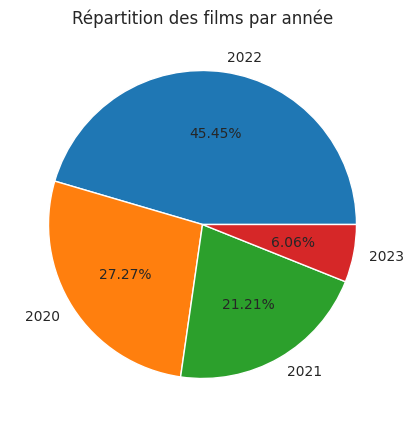

In [ ]:
# Création du diagramme à barres pour illustrer la répartition des films
fig, axes = plt.subplots(figsize=(8, 5))

sns.set_style("whitegrid") # Set style for chart

data = df_films_halloween_annee['count'].tolist()
labels = df_films_halloween_annee['annee_sortie'].tolist()

plt.pie(data,
        labels=labels,
        autopct = lambda x: str(round(x, 2)) + '%')

# Ajout des titres et labels
plt.title("Répartition des films par année")


# Affichage du graphique
plt.show()

### Statistiques sur la durée des films

In [ ]:
# la moyenne des films est de 89mn soit presque de 1h30
halloween_movies['duree'] = halloween_movies['duree'].astype('int64')
halloween_movies['duree'].describe()

,duree
count,33.000000
mean,89.515152
std,12.145270
min,53.000000
25%,81.000000
50%,90.000000
75%,98.000000
max,112.000000


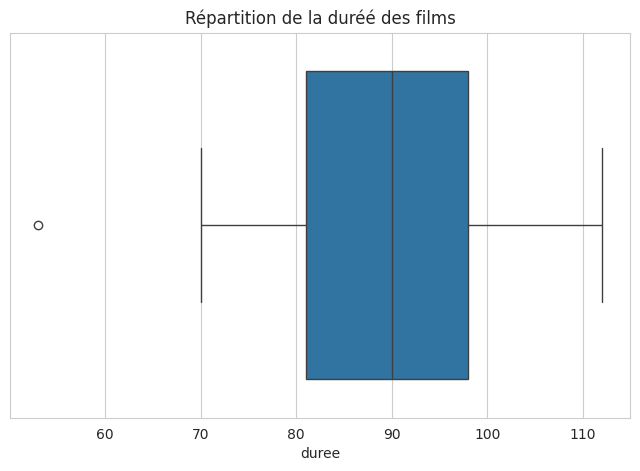

In [ ]:
# répartition dans un boxplot pour voir sa distribution

# Création du diagramme à barres pour illustrer la répartition des films
fig, axes = plt.subplots(figsize=(8, 5))
sns.boxplot(x="duree", data=halloween_movies)

# Ajout des titres et labels
plt.title("Répartition de la duréé des films")

# Affichage du graphique
plt.show()

In [ ]:
# supprimmer cet colonne car inutile pour la suite
halloween_movies = halloween_movies.drop(['description_en_clean'], axis=1)

### extraction du dataset halloween en csv

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
halloween_movies.to_csv('halloween_movies.csv', index=False)

# Explications :
# - 'halloween_movies.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

### Concernat la dataset familial et christmas

In [ ]:
familial_christmas_movies

,id_film,titre_original,annee_sortie,duree,genres,acteurs,personnage_film,directeur,moyenne_notes,nombre_votes,description_en,popularite,chemin_affiche,description_fr,description_en_clean
3,tt10081788,L'oiseau de paradis,2020,89,Drama,"['Sebastian Urzendowsky', 'Blanche-Neige Huri'...","['Teivi', 'Yasmina', 'Député Gilot']",Paul Manate,5.2,27.0,While Teivi is just a typical ambitious young ...,1.359,/bFb8rrph39j9lHK0vyevfDA4Zyk.jpg,"Jeune assistant parlementaire métis, amoral et...",teivi typical ambitious young man tahitian gol...
11,tt10143308,Tout nous sourit,2020,101,Comedy,"['Elsa Zylberstein', 'Stéphane De Groodt', 'Gu...","['Audrey Pottier', 'Jérôme Pottier', 'Henri Po...",Mélissa Drigeard,5.4,371.0,"The members of an apparently happy couple, eac...",2.680,/uyZG3WYk3oUqbRYunL92N8MFzZT.jpg,Tout sourit à Audrey et Jérôme. Ils ont trois ...,member apparently happy couple respective love...
15,tt10233406,Les blagues de Toto,2020,84,"Comedy,Family","['Gavril Dartevelle', 'Guillaume de Tonquédec'...","['Toto', 'Jérôme, le papa de Toto', 'Sylvie, l...",Pascal Bourdiaux,4.0,190.0,"Back-to-school! For troublemaker Toto, it’s th...",3.014,/4tZzPJHuszU7SxcqYTh7KH6cwBW.jpg,"A l’école, Toto est bien plus doué pour faire ...",backtoschool troublemaker toto good playground...
17,tt10251538,10 jours sans maman,2020,104,"Comedy,Family","['Franck Dubosc', 'Aure Atika', 'Alice David']","['Antoine Mercier', 'Isabelle Mercier', 'Julia']",Ludovic Bernard,5.4,1297.0,Antoine is the Head of HR of a big company. Ma...,7.750,/xEbSztKAAwIljX8A537HeZDKXUS.jpg,"Antoine, DRH d'une grande enseigne de bricolag...",antoine head hr big company manage people thin...
27,tt10369344,L'aventure des Marguerite,2020,89,"Comedy,Family,Fantasy","['Lila Gueneau', 'Lila Gueneau', 'Alice Pol']","['Margot', 'Marguerite', 'Tante Alice']",Pierre Coré,6.1,342.0,Margot and Marguerite are 12-year-old girls wh...,3.531,/dneHtelc4qqqOJzzaGzpixjA88W.jpg,Marguerite et Margot ont toutes les deux douze...,margot marguerite 12yearold girl seem differen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,tt21909950,Hawa,2022,104,"Comedy,Drama,Family","['Sania Halifa', 'Oumou Sangaré', 'Yseult']","['Hawa', 'Maminata Diawara', 'Yseult']",Maïmouna Doucouré,5.2,465.0,A teenage girl lives with her grandmother and ...,8.174,/p6DhbsX1EuSJMtuOGsENkIOx1tt.jpg,"Hawa, une adolescente de 15 ans, vit seule ave...",teenage girl live grandmother worry remove soc...
594,tt23435128,23 décembre,2022,101,Romance,"['François Arnaud', 'Michel Barrette', 'Pierre...","['Alex', 'Normand', 'Homme faché']",Miryam Bouchard,6.0,256.0,The choral film tells the intertwined destinie...,1.708,/uBtJgO1erpO1zJDWpWlsXny3ygt.jpg,"C'est le 23 décembre, avant-veille de Noël. Un...",choral film tell intertwine destiny several ch...
610,tt25750424,Voyages en Italie,2023,91,"Comedy,Romance","['Philippe Katerine', 'Sophie Letourneur']","['Jean-Philippe', 'Sophie']",Sophie Letourneur,6.0,215.0,A French couple burnt out by the routine of th...,2.137,/ij7pCTFiAIE3fkaDPU90xZ455X5.jpg,Une escapade romantique peut-elle raviver la f...,french couple burn routine daily family life d...
662,tt7534136,Petit vampire,2020,85,"Animation,Family,Fantasy","['Camille Cottin', 'Louise Lacoste', 'Louise L...","['Madame Pandora', 'Petit Vampire', 'Bois Dorm...",Joann Sfar,6.3,565.0,Little Vampire lives in a haunted house with a...,3.475,/mLd9FVJTwnPO3ERv82ea5IZo6Hl.jpg,Petit Vampire vit dans une maison hantée avec ...,little vampire life haunt house merry group mo...


In [ ]:
# Nombre de films sur ce thème : 68 films
familial_christmas_movies.shape

(68, 15)

In [ ]:
# répartition des films en fonction des 5 dernière année
df_films_christmas_annee = familial_christmas_movies['annee_sortie'].value_counts().reset_index()
df_films_christmas_annee

,annee_sortie,count
0,2022,23
1,2021,20
2,2020,15
3,2023,10


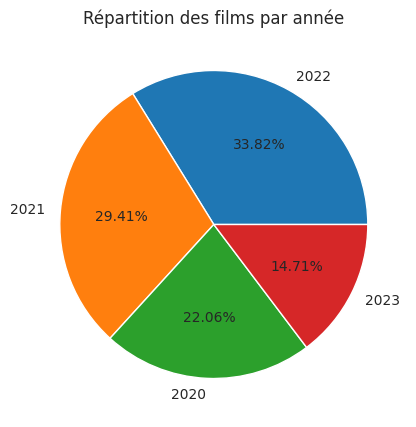

In [ ]:
# Création du diagramme à barres pour illustrer la répartition des films
fig, axes = plt.subplots(figsize=(8, 5))

sns.set_style("whitegrid") # Set style for chart

data = df_films_christmas_annee['count'].tolist()
labels = df_films_christmas_annee['annee_sortie'].tolist()

plt.pie(data,
        labels=labels,
        autopct = lambda x: str(round(x, 2)) + '%')

# Ajout des titres et labels
plt.title("Répartition des films par année")


# Affichage du graphique
plt.show()

### Statistiques sur la durée des films

In [ ]:
# la moyenne des films est de 96mn soit un peu plus de 1h30
familial_christmas_movies['duree'] = familial_christmas_movies['duree'].astype('int64')
familial_christmas_movies['duree'].describe()

<ipython-input-460-7a2a1554c246>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  familial_christmas_movies['duree'] = familial_christmas_movies['duree'].astype('int64')


,duree
count,68.000000
mean,95.941176
std,10.916074
min,70.000000
25%,87.000000
50%,96.000000
75%,103.000000
max,127.000000


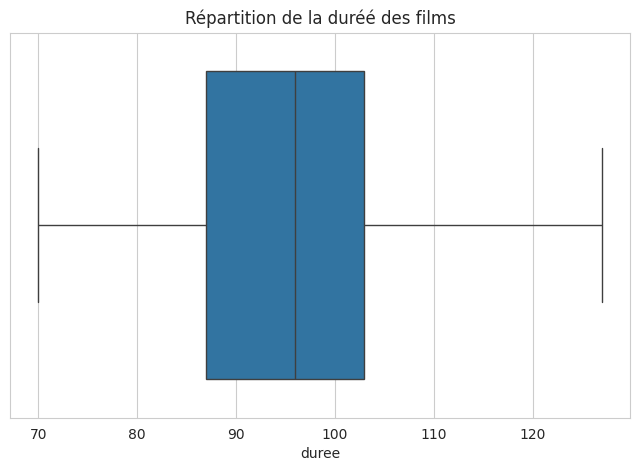

In [ ]:
# répartition dans un boxplot pour voir sa distribution

# Création du diagramme à barres pour illustrer la répartition des films
fig, axes = plt.subplots(figsize=(8, 5))
sns.boxplot(x="duree", data=familial_christmas_movies)

# Ajout des titres et labels
plt.title("Répartition de la duréé des films")

# Affichage du graphique
plt.show()

In [ ]:
# supprimmer cet colonne car inutile pour la suite
familial_christmas_movies = familial_christmas_movies.drop(['description_en_clean'], axis=1)

### extraction du dataset familial_christmas_movies en csv

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
familial_christmas_movies.to_csv('familial_christmas_movies.csv', index=False)

# Explications :
# - 'familial_christmas_movies.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

### Concernant la dataset Animation et familial

In [ ]:
len(animation_movies)

149

In [ ]:
# Filtrer les films contenant "Drama" mais ne contenant pas "Animation"
animation_movies = animation_movies.loc[
    ~animation_movies['genres'].str.contains('Drama', na=False) |  # Pas "Drama"
    animation_movies['genres'].str.contains('Animation', na=False)  # Ou contient "Animation"
]

In [ ]:
# Ce dataset contient 69 films
animation_movies.shape

(69, 15)

In [ ]:
# répartition des films en fonction des 5 dernière année
df_films_animation_annee = animation_movies['annee_sortie'].value_counts().reset_index()
df_films_animation_annee

,annee_sortie,count
0,2021,25
1,2022,25
2,2020,10
3,2023,8
4,2024,1


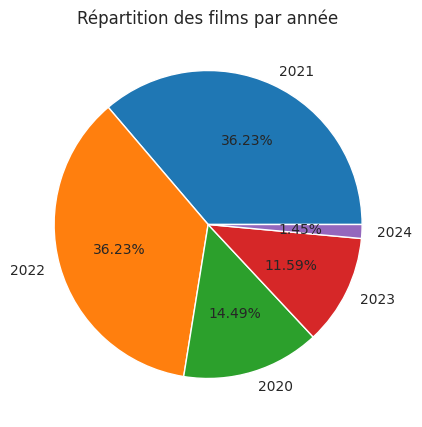

In [ ]:
# Création du diagramme à barres pour illustrer la répartition des films
fig, axes = plt.subplots(figsize=(8, 5))

sns.set_style("whitegrid") # Set style for chart

data = df_films_animation_annee['count'].tolist()
labels = df_films_animation_annee['annee_sortie'].tolist()

plt.pie(data,
        labels=labels,
        autopct = lambda x: str(round(x, 2)) + '%')

# Ajout des titres et labels
plt.title("Répartition des films par année")


# Affichage du graphique
plt.show()

### Statistiques sur la durée des films

In [ ]:
# la moyenne des films est de 90mn soit 1h30
animation_movies['duree'] = animation_movies['duree'].astype('int64')
animation_movies['duree'].describe()

<ipython-input-494-f5b8008769aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animation_movies['duree'] = animation_movies['duree'].astype('int64')


,duree
count,69.000000
mean,90.246377
std,11.134744
min,61.000000
25%,84.000000
50%,91.000000
75%,98.000000
max,125.000000


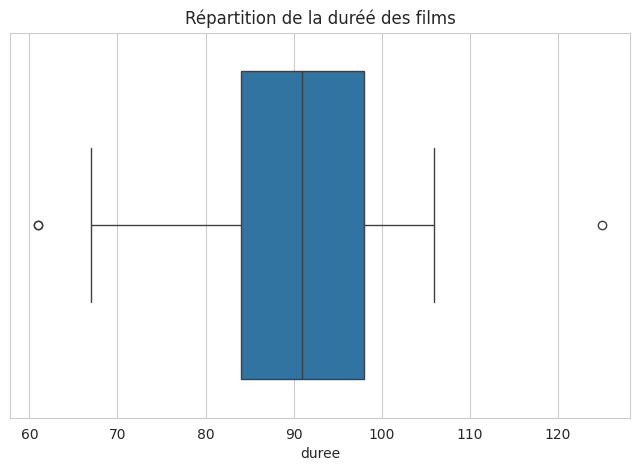

In [ ]:
# répartition dans un boxplot pour voir sa distribution

# Création du diagramme à barres pour illustrer la répartition des films
fig, axes = plt.subplots(figsize=(8, 5))
sns.boxplot(x="duree", data=animation_movies)

# Ajout des titres et labels
plt.title("Répartition de la duréé des films")

# Affichage du graphique
plt.show()

In [ ]:
# supprimmer cet colonne car inutile pour la suite
animation_movies = animation_movies.drop(['description_en_clean'], axis=1)

### extraction du dataset familial_christmas_movies en csv

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
animation_movies.to_csv('animation_movies.csv', index=False)

# Explications :
# - 'animation_movies.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.